In [2]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import scipy.io as sio
from joblib import Parallel, delayed
import os
import pickle
import argparse
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams.update({'font.size': 20})

In [3]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_regression_info.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

In [14]:
'''load original neural data'''

monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')
bhv_path = os.path.join(root_dir, 'Behavior/')

binsize = 0.01
gauss_SD = 0.02/binsize

all_sess_neural_data = []

for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(
            f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(
                f'RastVect-{monkey_name}(\\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

            neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)
            
            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(
                bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            # only keep chosen image, chosen loc, reward, block type, block id
            task_info = task_info[:, [0, 1, 2, 9, 7]].astype(float)

            trial_mask = task_info[:, 4] <= 24
            task_info = task_info[trial_mask]
            neural_data = neural_data[trial_mask]

            neuron_mask = np.nonzero(np.min(neural_data.sum(0), 1))[0]
            neural_data = neural_data[:, neuron_mask, :]            
            
            all_sess_neural_data.append(neural_data)
            
            print("aligned to: " + aligned_event + ", monkey: " + monkey_name + ", session: " + sess_date)

            

aligned to: StimOnset, monkey: W, session: 20160122
aligned to: StimOnset, monkey: W, session: 20160112
aligned to: StimOnset, monkey: W, session: 20160121
aligned to: StimOnset, monkey: W, session: 20160113
aligned to: StimOnset, monkey: V, session: 20160929
aligned to: StimOnset, monkey: V, session: 20160930
aligned to: StimOnset, monkey: V, session: 20161005
aligned to: StimOnset, monkey: V, session: 20161017


In [8]:
def plot_mean_se(ax, xxx, yyy, color, label, axis):
    mean = yyy.mean(axis)
    se = yyy.std(axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, label=label)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

In [9]:
all_sess_exp_var = np.concatenate(all_sess_regression_info['exp_vars'], axis=1)
all_sess_betas = np.concatenate(all_sess_regression_info['betas'], axis=1)
xxx = np.linspace(-1500, 1500, num=300)

In [10]:
def plot_time_varying_correlation(xxx, yyy, ax, title, vlim=0.4, metric='corr'):        
    
    if metric=='cosine':
        sim = (xxx/np.linalg.norm(xxx, axis=-1, keepdims=True))@\
                    (yyy/np.linalg.norm(yyy, axis=-1, keepdims=True)).T
    if metric=='dot':
        sim = (xxx)@(yyy).T
    elif metric=='corr':
        sim = np.corrcoef(xxx, yyy)[:300,300:]
    elif metric=='cov':
        sim = np.cov(xxx, yyy)[:300,300:]
    
    
    if vlim is None:
        vlim = np.abs(sim).max()
    
    sns.heatmap(sim, 
                cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                ax=ax, square=True, cbar_kws={'shrink': 0.8})
    ax.axvline(250, ls=':', c='grey')
    ax.axhline(250, ls=':', c='grey')
    ax.axvline(150, ls=':', c='grey')
    ax.axhline(150, ls=':', c='grey')
    ax.axvline(90, ls=':', c='grey')
    ax.axhline(90, ls=':', c='grey')
    ax.set_title(title)
    ax.set_xticks([90, 150, 250], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])
    
    return sim


    

## Presence of task-relevant information in the population

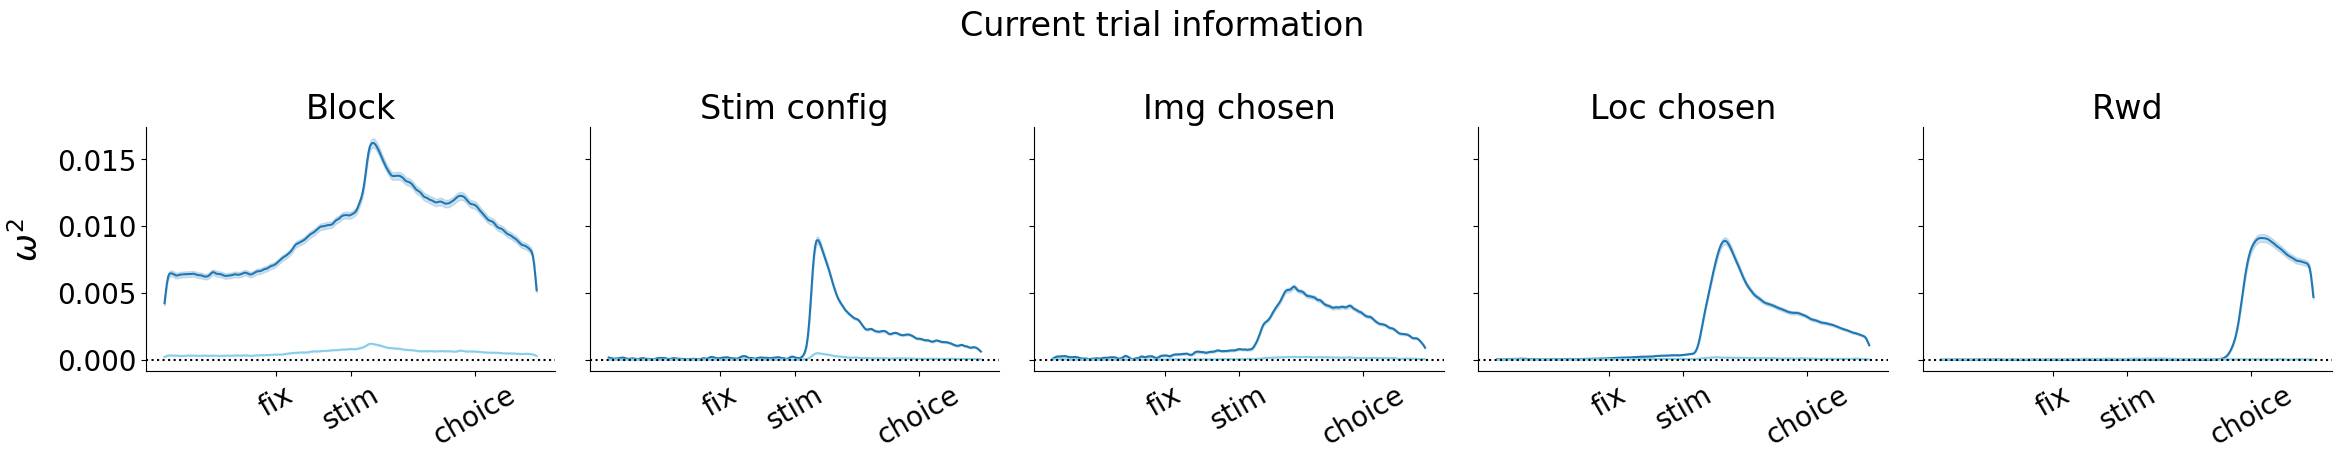

In [196]:
fig, axes = plt.subplots(1,5, sharey=True, sharex=True, figsize=(4.8*5, 4.8))

plot_mean_se(axes[0], xxx, all_sess_exp_var[...,2], color='tab:blue', label=None, axis=1)
plot_mean_se(axes[0], xxx, all_sess_exp_var[...,1], color='skyblue', label=None, axis=1)
axes[0].set_title('Block')

plot_mean_se(axes[1], xxx, all_sess_exp_var[...,5], color='tab:blue', label=None, axis=1)
plot_mean_se(axes[1], xxx, all_sess_exp_var[...,4], color='skyblue', label=None, axis=1)
axes[1].set_title('Stim config')

plot_mean_se(axes[2], xxx, all_sess_exp_var[...,8], color='tab:blue', label=None, axis=1)
plot_mean_se(axes[2], xxx, all_sess_exp_var[...,7], color='skyblue', label=None, axis=1)
axes[2].set_title('Img chosen')

plot_mean_se(axes[3], xxx, all_sess_exp_var[...,9], color='tab:blue', label=None, axis=1)
plot_mean_se(axes[3], xxx, all_sess_exp_var[...,10], color='skyblue', label=None, axis=1)
axes[3].set_title('Loc chosen')

plot_mean_se(axes[4], xxx, all_sess_exp_var[...,11], color='tab:blue', label=None, axis=1)
plot_mean_se(axes[4], xxx, all_sess_exp_var[...,13], color='skyblue', label=None, axis=1)
axes[4].set_title('Rwd')

for a in axes:
    a.axhline(0, ls=':', c='k')
    a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'], rotation=30)

# axes[1].plot(xxx, all_sess_exp_var.mean(1)[:,7:9])
# axes[1].set_title('Img chosen')
# axes[2].plot(xxx, all_sess_exp_var.mean(1)[:,9:11])
# axes[2].set_title('Loc chosen')
# axes[3].plot(xxx, all_sess_exp_var.mean(1)[:,11:13])
# axes[3].set_title('Rwd')


# axes[0].set_ylim([-0.001, 0.05])
# fig.supxlabel('Event (ms)')
fig.supylabel('$\\omega^2$')
fig.suptitle('Current trial information')

sns.despine()

fig.tight_layout()

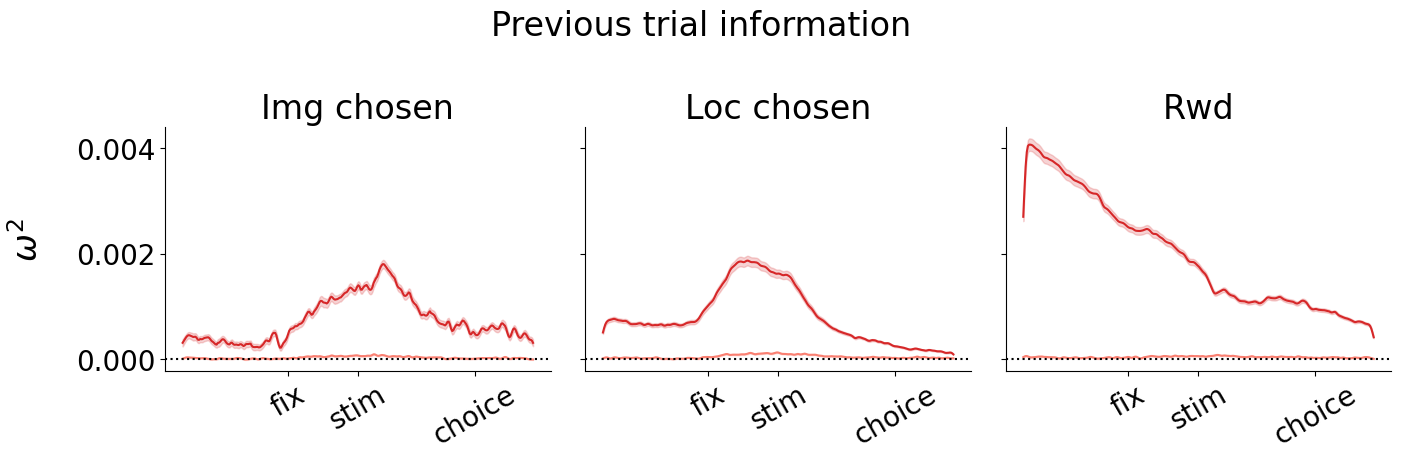

In [197]:
fig, axes = plt.subplots(1,3, sharey=True, sharex=True, figsize=(4.8*3, 4.8))

plot_mean_se(axes[0], xxx, all_sess_exp_var[...,15], color='tab:red', label=None, axis=1)
plot_mean_se(axes[0], xxx, all_sess_exp_var[...,14], color='salmon', label=None, axis=1)
axes[0].set_title('Img chosen')

plot_mean_se(axes[1], xxx, all_sess_exp_var[...,16], color='tab:red', label=None, axis=1)
plot_mean_se(axes[1], xxx, all_sess_exp_var[...,17], color='salmon', label=None, axis=1)
axes[1].set_title('Loc chosen')

plot_mean_se(axes[2], xxx, all_sess_exp_var[...,18], color='tab:red', label=None, axis=1)
plot_mean_se(axes[2], xxx, all_sess_exp_var[...,19], color='salmon', label=None, axis=1)
axes[2].set_title('Rwd')

for a in axes:
    a.axhline(0, ls=':', c='k')
    a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'], rotation=30)

# axes[0].set_ylim([-0.001, 0.05])
# fig.supxlabel('Time (ms)')
fig.supylabel('$\\omega^2$')
fig.suptitle('Previous trial information')

sns.despine()

fig.tight_layout()

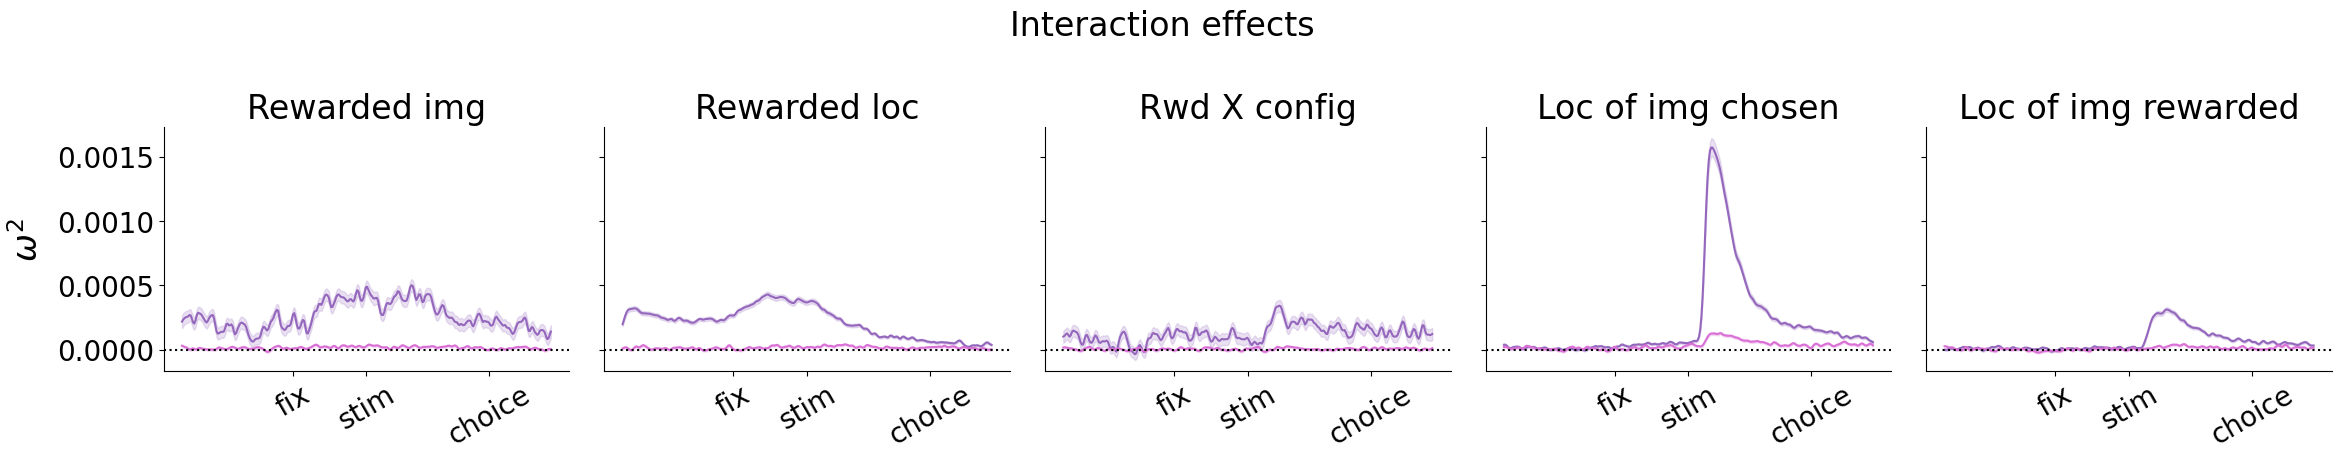

In [198]:
fig, axes = plt.subplots(1,5, sharey=True, sharex=True, figsize=(4.8*5, 4.8))

plot_mean_se(axes[0], xxx, all_sess_exp_var[...,24], color='tab:purple', label=None, axis=1)
plot_mean_se(axes[0], xxx, all_sess_exp_var[...,23], color='orchid', label=None, axis=1)
axes[0].set_title('Rewarded img')

plot_mean_se(axes[1], xxx, all_sess_exp_var[...,20], color='tab:purple', label=None, axis=1)
plot_mean_se(axes[1], xxx, all_sess_exp_var[...,21], color='orchid', label=None, axis=1)
axes[1].set_title('Rewarded loc')

plot_mean_se(axes[2], xxx, all_sess_exp_var[...,29], color='tab:purple', label=None, axis=1)
plot_mean_se(axes[2], xxx, all_sess_exp_var[...,28], color='orchid', label=None, axis=1)
axes[2].set_title('Rwd X config')

plot_mean_se(axes[3], xxx, all_sess_exp_var[...,25], color='tab:purple', label=None, axis=1)
plot_mean_se(axes[3], xxx, all_sess_exp_var[...,26], color='orchid', label=None, axis=1)
axes[3].set_title('Loc of img chosen')


plot_mean_se(axes[4], xxx, all_sess_exp_var[...,30], color='tab:purple', label=None, axis=1)
plot_mean_se(axes[4], xxx, all_sess_exp_var[...,31], color='orchid', label=None, axis=1)
axes[4].set_title('Loc of img rewarded')

for a in axes:
    a.axhline(0, ls=':', c='k')
    a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'], rotation=30)

# axes[0].set_ylim([-0.001, 0.05])
# fig.supxlabel('Time (ms)')
fig.supylabel('$\\omega^2$')
fig.suptitle('Interaction effects')

sns.despine()

fig.tight_layout()

## Congruent coding of choice history

In [ ]:
plt.rcParams.update({'font.size': 12})

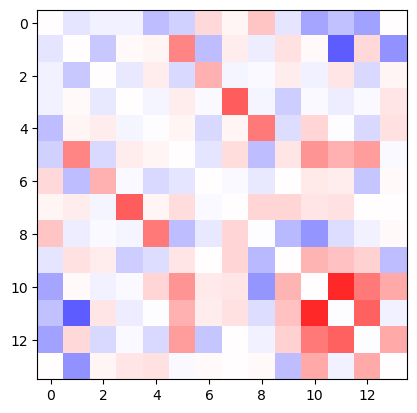

In [108]:
plt.imshow(np.corrcoef(all_sess_betas[:].mean(0)[:,[72,73,
                                                    74,75,
                                                    100,101,
                                                    102,103,
                                                    104,105,
                                                    130,131,
                                                    156,157]].T)-np.eye(14), 
           cmap='seismic', vmin=-0.8, vmax=0.8)


In [226]:
np.corrcoef(all_sess_betas[:].mean(0)[:, 72], 
            all_sess_betas[:].mean(0)[:,100]-all_sess_betas[:].mean(0)[:,101])

array([[ 1.        , -0.07730717],
       [-0.07730717,  1.        ]])

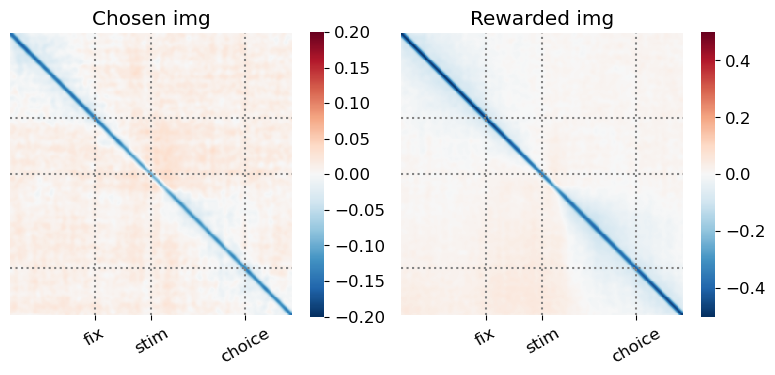

In [20]:
fig, axes = plt.subplots(1,2, figsize=(8, 4))

all_sims_img_cr = []
all_sims_img_wlsl = []



for iii in range(22):
    all_sims_img_cr.append(np.corrcoef(all_sess_betas[...,50+iii], 
                                       all_sess_betas[...,108+iii])[:300,300:])
    all_sims_img_wlsl.append(np.corrcoef(all_sess_betas[...,50+iii], 
                                       all_sess_betas[...,78+iii])[:300,300:])

vlim=0.2
sns.heatmap(np.stack(all_sims_img_cr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[0], square=True, cbar_kws={'shrink': 0.8})
axes[0].set_title('Chosen img')

vlim=0.5
sns.heatmap(np.stack(all_sims_img_wlsl).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[1], square=True, cbar_kws={'shrink': 0.8})
axes[1].set_title('Rewarded img')

for ax in axes:
    ax.axvline(250, ls=':', c='grey')
    ax.axhline(250, ls=':', c='grey')
    ax.axvline(150, ls=':', c='grey')
    ax.axhline(150, ls=':', c='grey')
    ax.axvline(90, ls=':', c='grey')
    ax.axhline(90, ls=':', c='grey')
    ax.set_xticks([90, 150, 250], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])

fig.tight_layout()


array([[ 1.        ,  0.97112686,  0.87628702, ..., -0.05535406,
        -0.05582083, -0.05502845],
       [ 0.97112686,  1.        ,  0.96365691, ..., -0.05941812,
        -0.05960447, -0.05847406],
       [ 0.87628702,  0.96365691,  1.        , ..., -0.06030778,
        -0.06002179, -0.05846238],
       ...,
       [-0.05535406, -0.05941812, -0.06030778, ...,  1.        ,
         0.99266935,  0.97307408],
       [-0.05582083, -0.05960447, -0.06002179, ...,  0.99266935,
         1.        ,  0.99333866],
       [-0.05502845, -0.05847406, -0.05846238, ...,  0.97307408,
         0.99333866,  1.        ]])

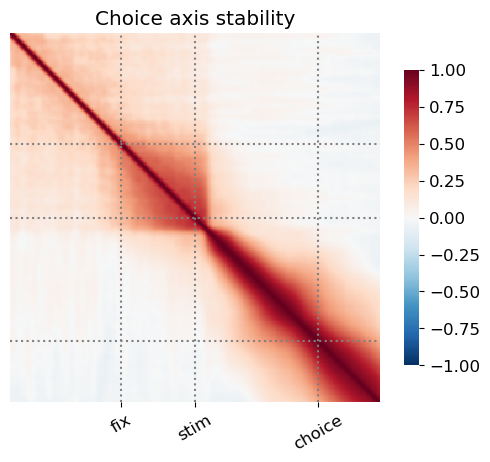

In [10]:
fig, axes = plt.subplots(1,1)

plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,72], 
                              axes, title='Choice axis stability', vlim=None)


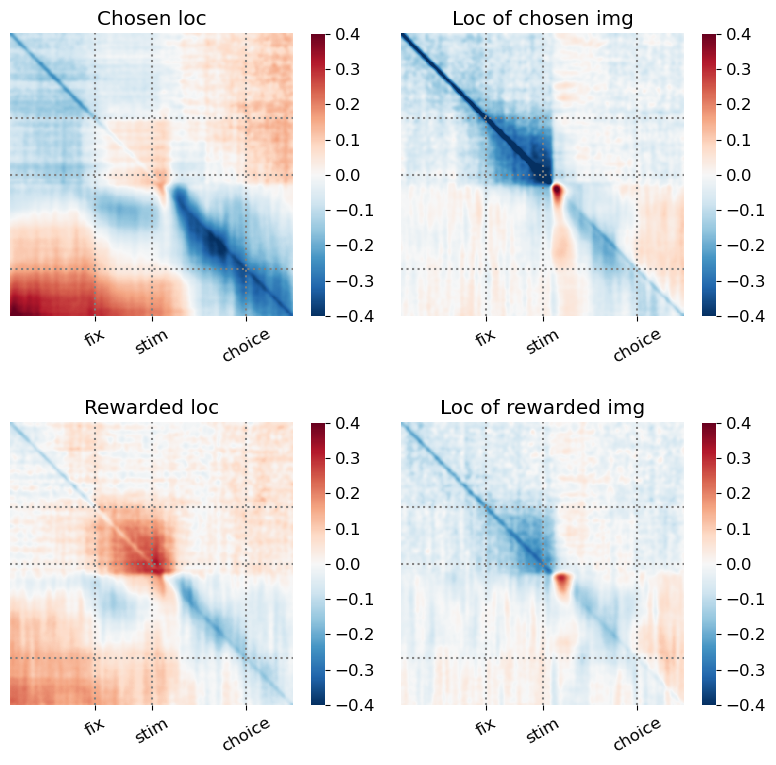

In [217]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img'))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()


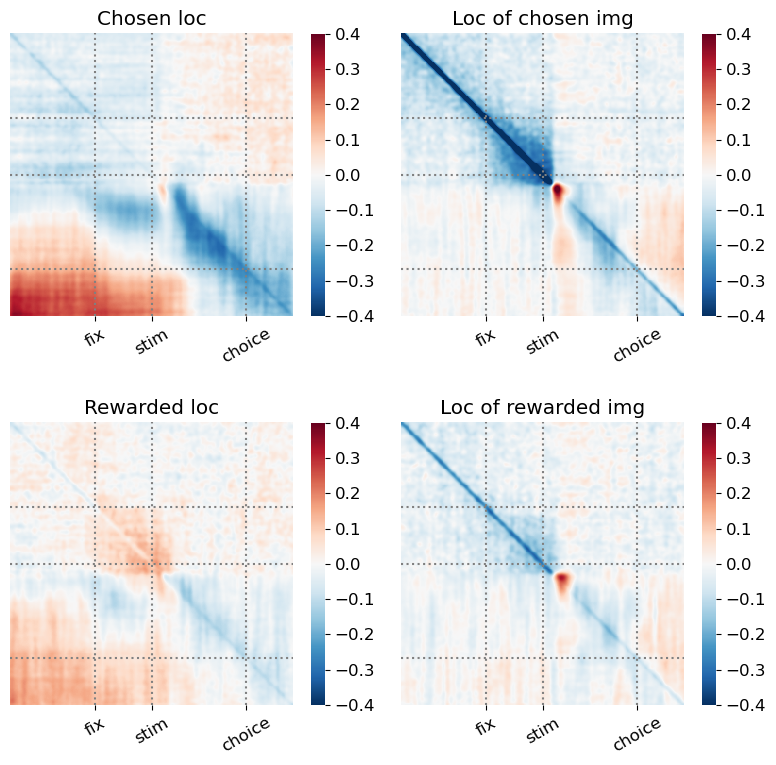

In [220]:
fig, axes = plt.subplots(2,2, figsize=(8, 8))

sims_what = []

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,100]+all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,130]+all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img'))

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,104]+all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,156]+all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()

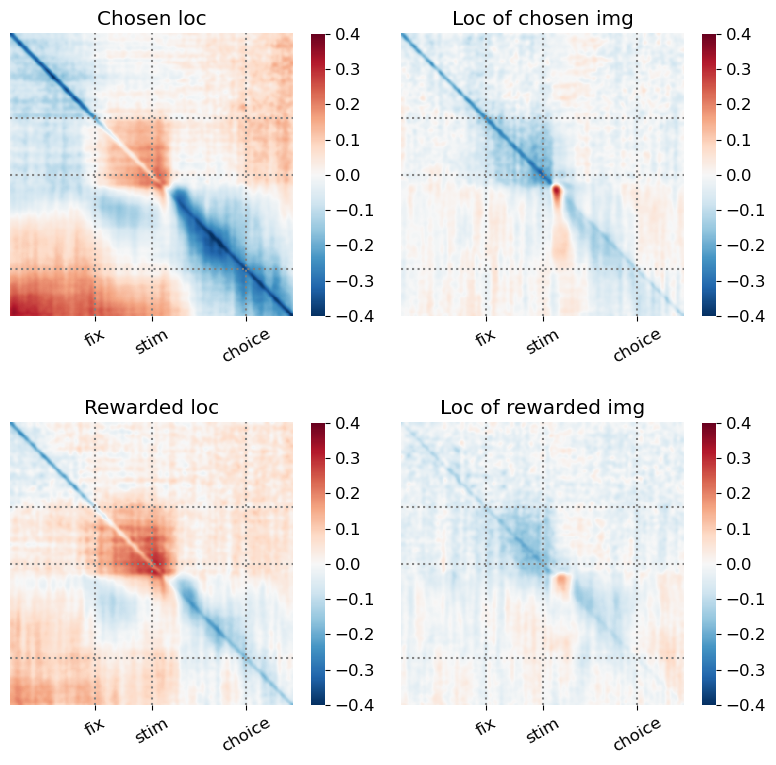

In [221]:
fig, axes = plt.subplots(2,2, figsize=(8, 8))


sims_where = []

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,100]-all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,130]-all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img'))

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,104]-all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,156]-all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()

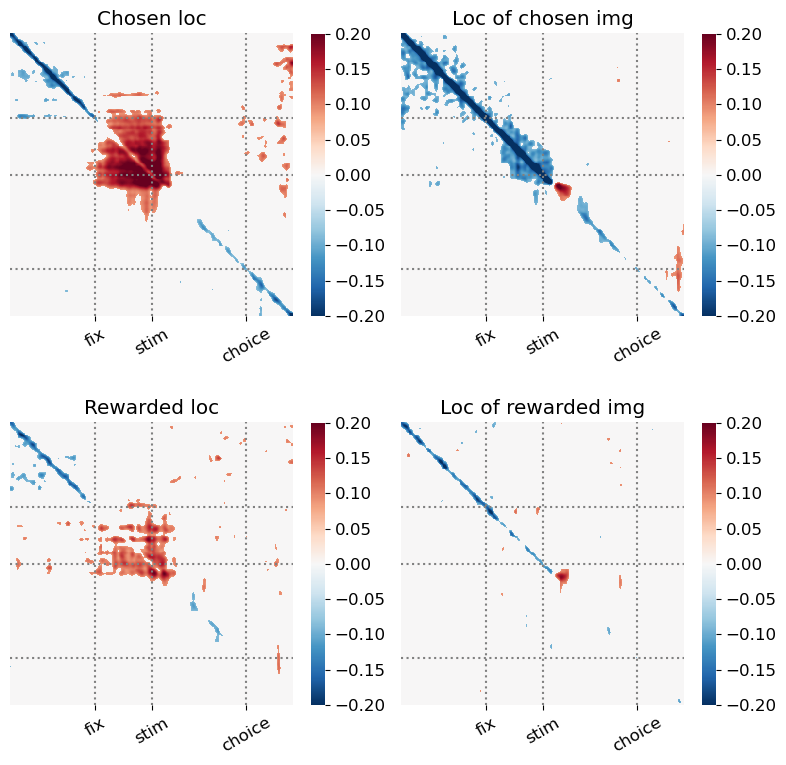

In [227]:
from scipy.stats import norm

fig, axes = plt.subplots(2,2, figsize=(8, 8))

ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]

vlim=0.2

n_neurons = all_sess_betas.shape[1]

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        if j==1:
            sims_diff = sims_what[i*2+j]-sims_where[i*2+j]
            sims_diff_z = (np.arctanh(sims_what[i*2+j])-np.arctanh(sims_where[i*2+j]))/np.sqrt(2/(n_neurons-3))
        else:
            sims_diff = sims_where[i*2+j]-sims_what[i*2+j]
            sims_diff_z = (np.arctanh(sims_where[i*2+j])-np.arctanh(sims_what[i*2+j]))/np.sqrt(2/(n_neurons-3))
        sns.heatmap(sims_diff*(np.abs(sims_diff_z)>norm.ppf(1-0.05/(300**2))), 
                    cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                    ax=ax, square=True, cbar_kws={'shrink': 0.8})
        ax.axvline(250, ls=':', c='grey')
        ax.axhline(250, ls=':', c='grey')
        ax.axvline(150, ls=':', c='grey')
        ax.axhline(150, ls=':', c='grey')
        ax.axvline(90, ls=':', c='grey')
        ax.axhline(90, ls=':', c='grey')
        ax.set_title(ylabel_names[i][j])
        ax.set_xticks([90, 150, 250], ['fix', 'stim', 'choice'], rotation=30)
        ax.set_yticks([], [])

fig.tight_layout()

## Dynamic arbitration signal

In [15]:
for idx_sess in range(8):
    print(all_sess_neural_data[idx_sess].shape)
    print(all_sess_regression_info['betas'][idx_sess].shape)

(1923, 564, 300)
(300, 564, 158)
(1914, 668, 300)
(300, 668, 158)
(1893, 659, 300)
(300, 659, 158)
(2033, 723, 300)
(300, 723, 158)
(1930, 868, 300)
(300, 868, 158)
(1929, 937, 300)
(300, 937, 158)
(1922, 1015, 300)
(300, 1015, 158)
(1956, 579, 300)
(300, 579, 158)


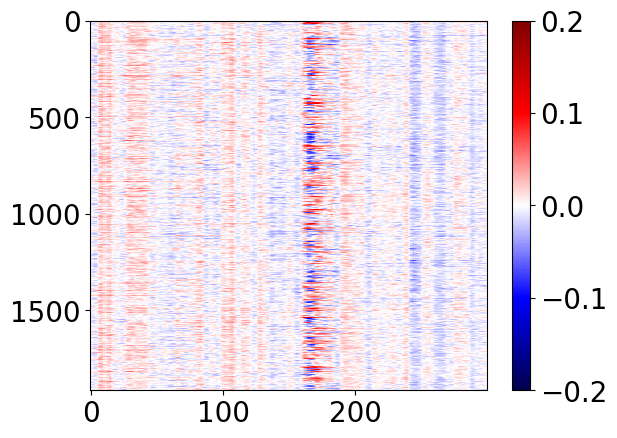

In [100]:
idx_sess = 1

plt.imshow((all_sess_neural_data[idx_sess].transpose((0,2,1))\
            *(all_sess_regression_info['betas'][idx_sess][...,130]-\
              all_sess_regression_info['betas'][idx_sess][...,131])[None]).sum(-1)[:],
          aspect='auto', interpolation='nearest', vmin=-0.2, vmax=0.2, cmap='seismic')
plt.colorbar()

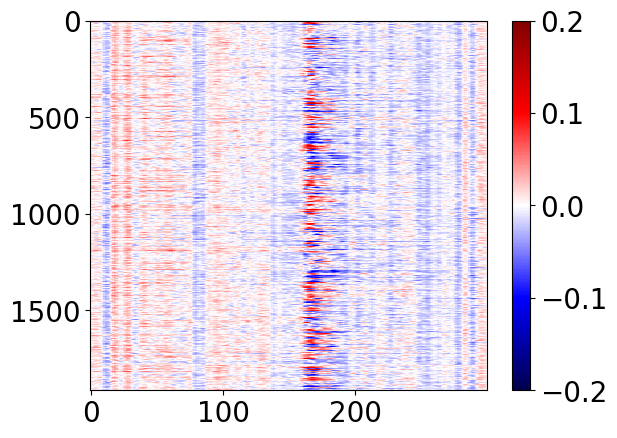

In [99]:
idx_sess = 1

plt.imshow((all_sess_neural_data[idx_sess].transpose((0,2,1))\
            *(all_sess_regression_info['betas'][idx_sess][...,130]+\
              all_sess_regression_info['betas'][idx_sess][...,131])[None]).sum(-1)[:],
          aspect='auto', interpolation='nearest', vmin=-0.2, vmax=0.2, cmap='seismic')
plt.colorbar()

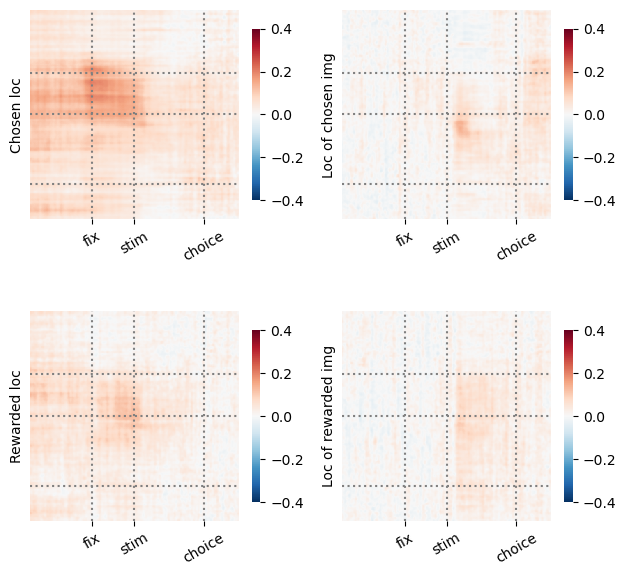

In [80]:
fig, axes = plt.subplots(2,2, figsize=(6.4, 6.4))

plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,16], 
                              axes[0,0], ylabel='Chosen loc')
plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,25], 
                              axes[0,1], ylabel='Loc of chosen img')

plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,20], 
                              axes[1,0], ylabel='Rewarded loc')
plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,30], 
                              axes[1,1], ylabel='Loc of rewarded img')

fig.tight_layout()


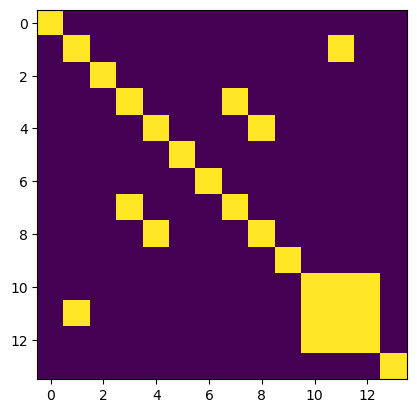

In [67]:
plt.imshow(np.abs(np.corrcoef(all_sess_betas[:].mean(0)\
                       [:,[72,73,74,75,100,101,102,103,104,105,130,131,156,157]].T))>0.2)


In [91]:
np.corrcoef(all_sess_betas[:].mean(0)[:,[100,104,130,156]].T)

array([[ 1.        ,  0.21174275,  0.06255917, -0.05883668],
       [ 0.21174275,  1.        , -0.16380073, -0.02447621],
       [ 0.06255917, -0.16380073,  1.        ,  0.21240906],
       [-0.05883668, -0.02447621,  0.21240906,  1.        ]])

In [45]:
normalized_betas.shape

(300, 6013, 158)

In [26]:
normalized_betas = all_sess_betas/(np.sum(all_sess_betas**2, axis=-1, keepdims=True)+1e-8)**0.5

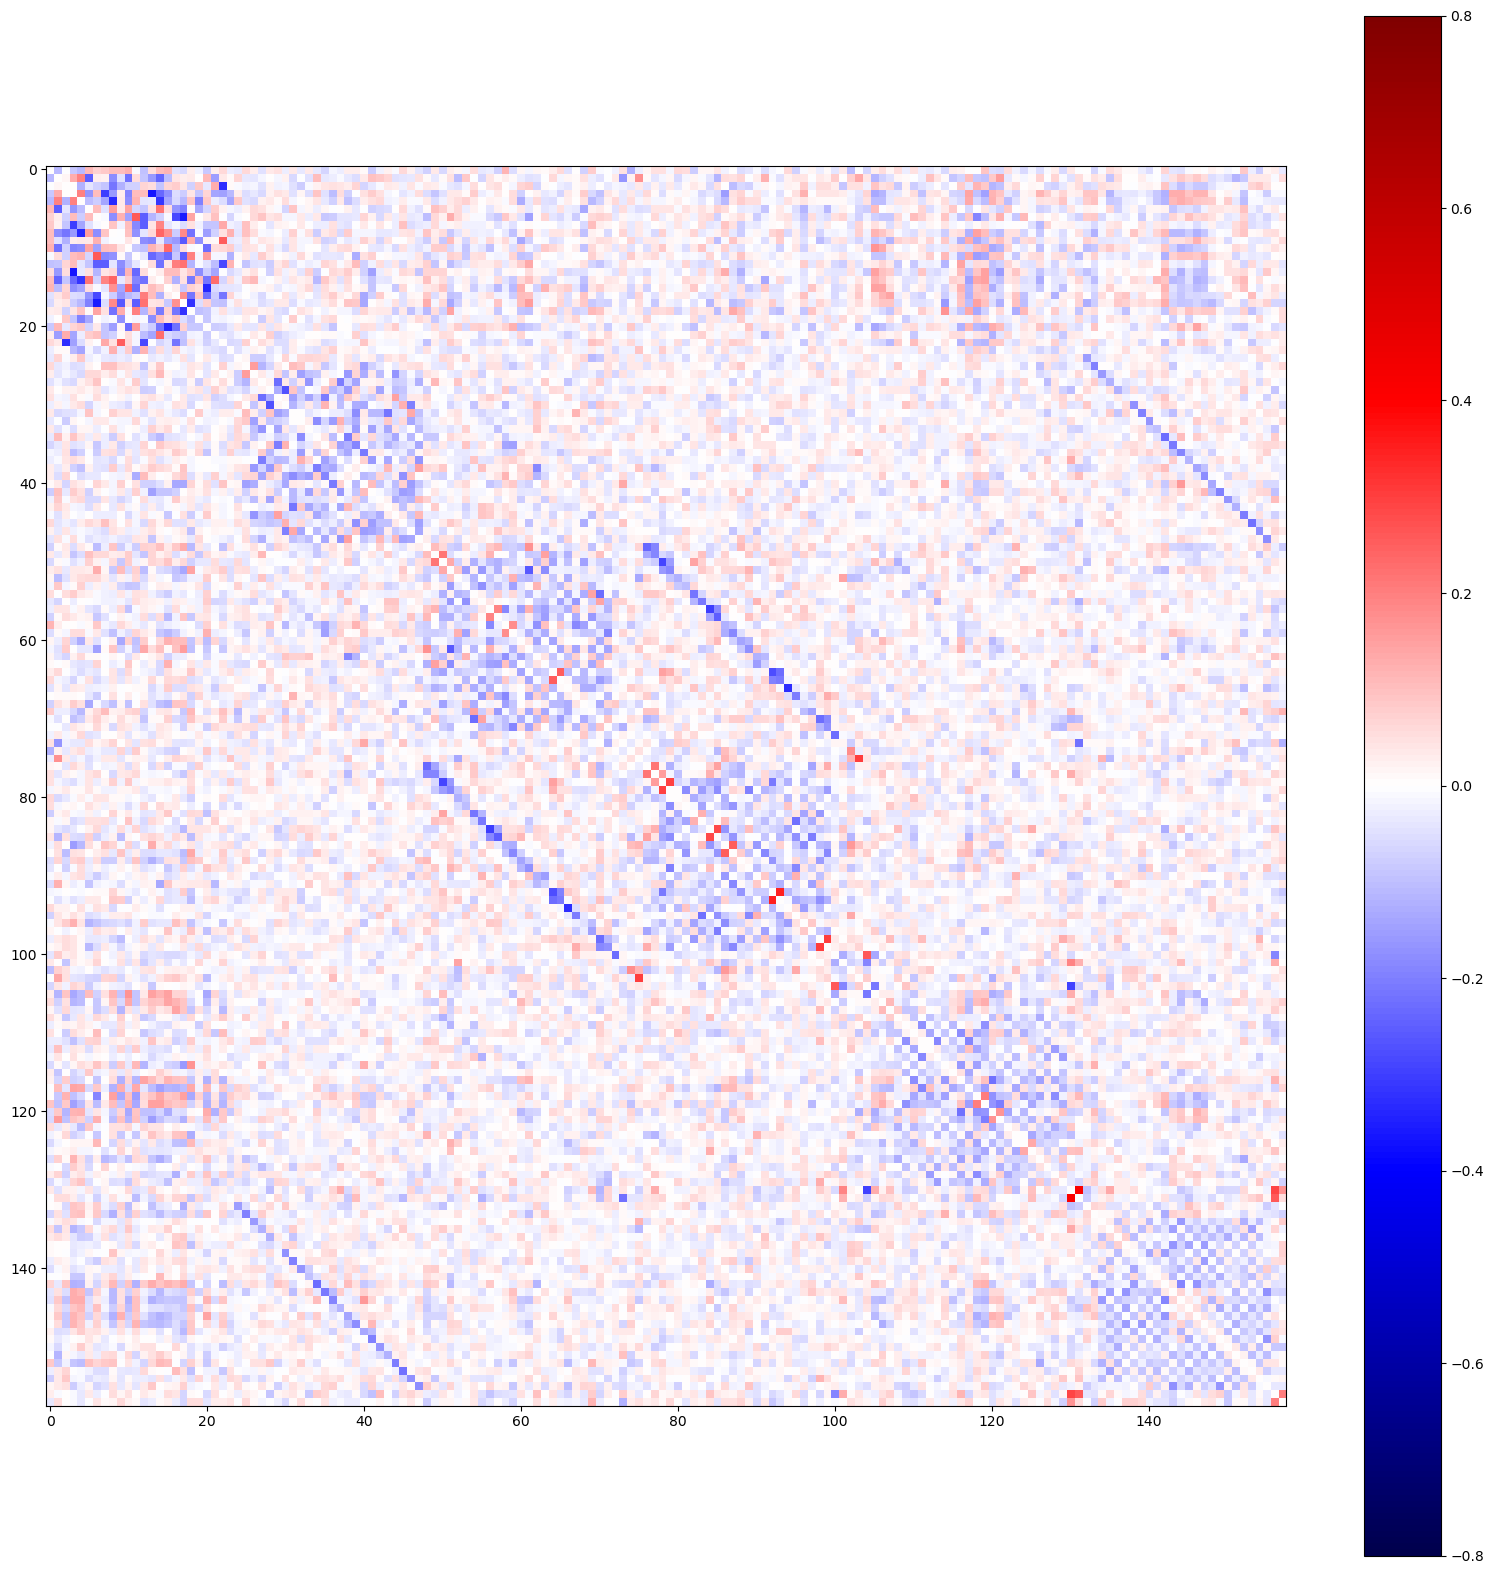

In [211]:
fig, axes = plt.subplots(figsize=(20,20))

all_beta_corrs = [np.corrcoef(np.mean(beta[150:200,:], 0).T)
                     for beta in all_sess_regression_info['betas']]

plt.imshow(np.mean(np.stack(all_beta_corrs), 0)*(np.abs(np.mean(np.stack(all_beta_corrs), 0))>0.)-np.eye(158), 
           vmin=-0.8, vmax=0.8, cmap='seismic')
plt.colorbar()

SignificanceResult(statistic=0.7203546809715273, pvalue=0.0)

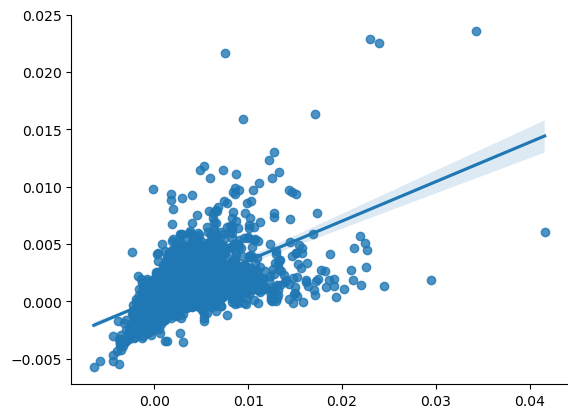

In [184]:
sns.regplot(x=all_sess_exp_var[:].mean(0)[:,8], y=all_sess_exp_var[:].mean(0)[:,15])
sns.despine()
stats.spearmanr(all_sess_exp_var[:].mean(0)[:,8], all_sess_exp_var[:].mean(0)[:,15])

PearsonRResult(statistic=0.3919361183061456, pvalue=5.321062360272099e-220)


(-0.01, 0.1)

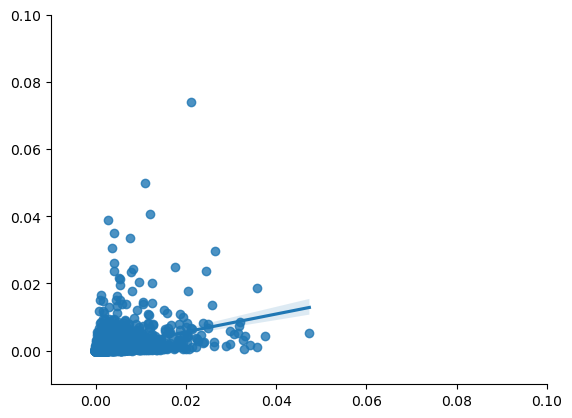

In [191]:
sns.regplot(x=all_sess_exp_var[:].mean(0)[:,9], y=all_sess_exp_var[:].mean(0)[:,16])
sns.despine()
print(stats.pearsonr(all_sess_exp_var[:].mean(0)[:,9], all_sess_exp_var[:].mean(0)[:,16]))
plt.xlim([-0.01, 0.1])
plt.ylim([-0.01, 0.1])

SignificanceResult(statistic=0.028377289362539304, pvalue=0.027774205407855374)

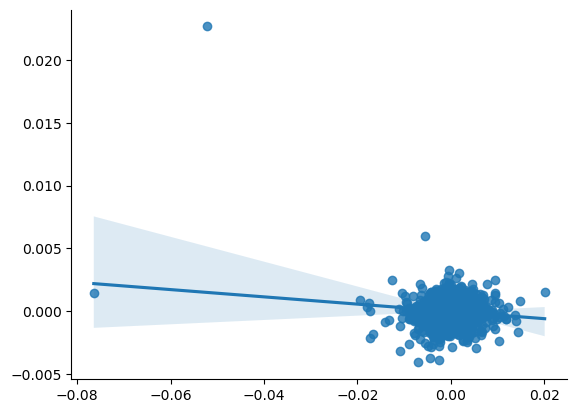

In [44]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,1], y=all_sess_betas[:].mean(0)[:,105])
sns.despine()
stats.spearmanr(all_sess_betas[:].mean(0)[:,1], all_sess_betas[:].mean(0)[:,105])

PearsonRResult(statistic=0.3250269761927396, pvalue=5.843051118963061e-148)

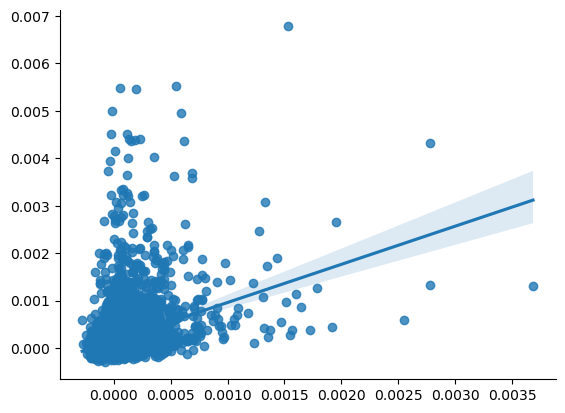

In [37]:
sns.regplot(x=all_sess_exp_var[:].mean(0)[:,30], y=all_sess_exp_var[:].mean(0)[:,25])
sns.despine()
stats.pearsonr(all_sess_exp_var[:].mean(0)[:,30], all_sess_exp_var[:].mean(0)[:,25])


SignificanceResult(statistic=0.25503777893829294, pvalue=6.566098893147044e-90)

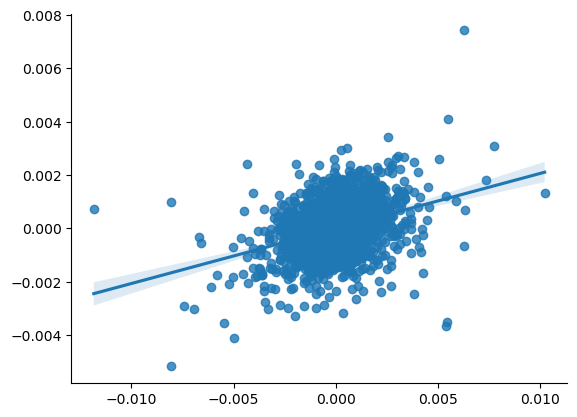

In [64]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,130], y=all_sess_betas[:].mean(0)[:,131])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,130], all_sess_betas[:].mean(0)[:,131])

SignificanceResult(statistic=0.12312520124277192, pvalue=9.513155975640868e-22)

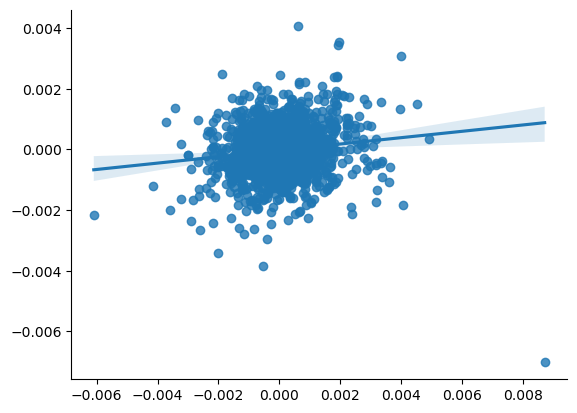

In [63]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,156], y=all_sess_betas[:].mean(0)[:,157])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,156], all_sess_betas[:].mean(0)[:,157])

SignificanceResult(statistic=-0.3056520367282683, pvalue=3.2069935396978157e-130)

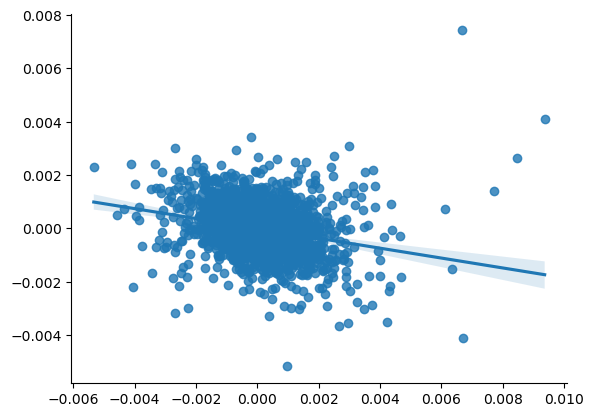

In [62]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,73], y=all_sess_betas[:].mean(0)[:,131])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,73], all_sess_betas[:].mean(0)[:,131])

SignificanceResult(statistic=-0.13879050851363214, pvalue=3.00583381972959e-27)

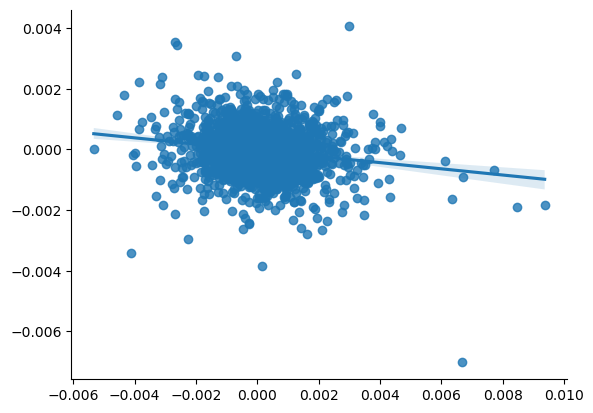

In [71]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,73], y=all_sess_betas[:].mean(0)[:,157])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,73], all_sess_betas[:].mean(0)[:,157])

SignificanceResult(statistic=-0.08498743289240852, pvalue=4.0894358213429616e-11)

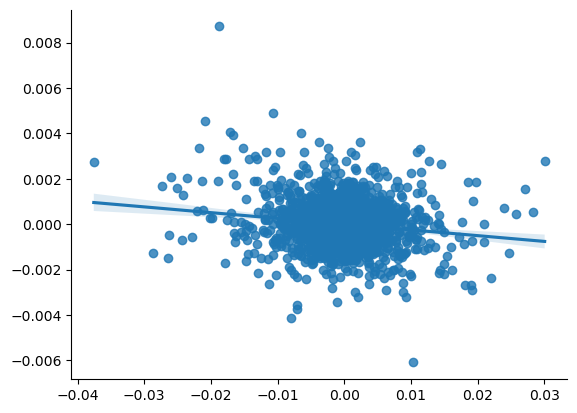

In [72]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,72], y=all_sess_betas[:].mean(0)[:,156])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,72], all_sess_betas[:].mean(0)[:,156])

SignificanceResult(statistic=0.1645016307417412, pvalue=9.667486286059218e-38)

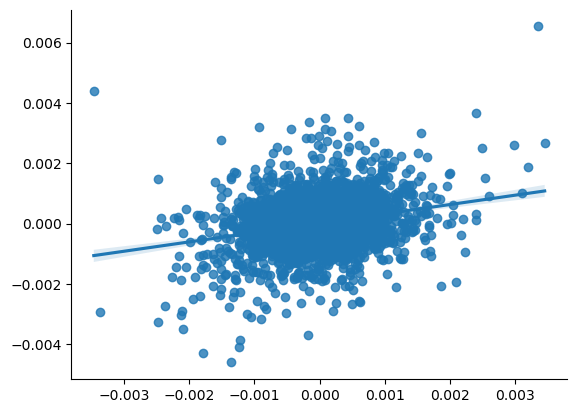

In [73]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,75], y=all_sess_betas[:].mean(0)[:,103])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,75], all_sess_betas[:].mean(0)[:,103])

SignificanceResult(statistic=0.19227904158567605, pvalue=3.584729530824427e-51)

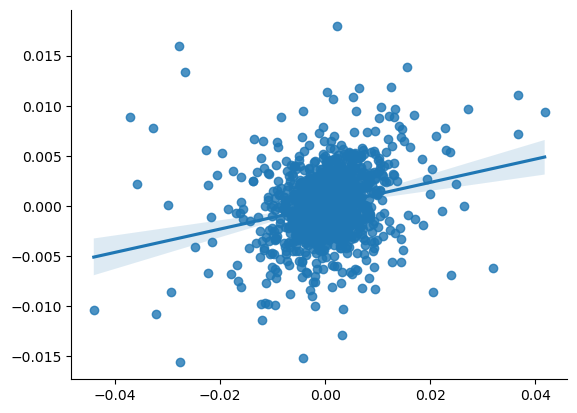

In [86]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,100], y=all_sess_betas[:].mean(0)[:,104])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,100], all_sess_betas[:].mean(0)[:,104])

SignificanceResult(statistic=0.08979683717266496, pvalue=3.04108401026487e-12)

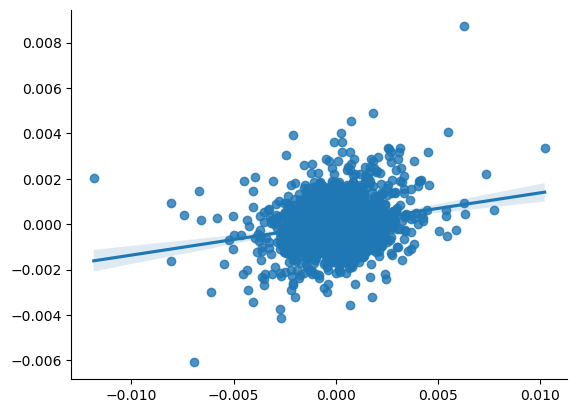

In [80]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,130], y=all_sess_betas[:].mean(0)[:,156])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,130], all_sess_betas[:].mean(0)[:,156])

SignificanceResult(statistic=0.1645016307417412, pvalue=9.667486286059218e-38)

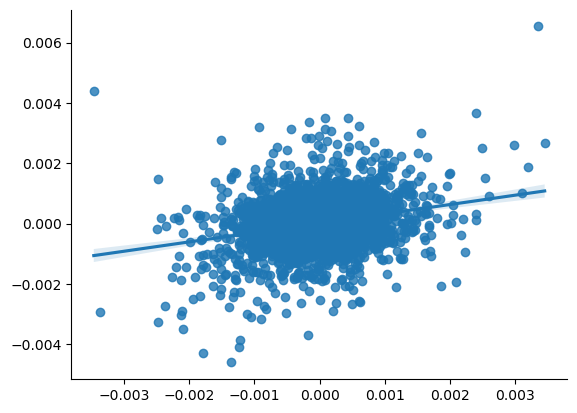

In [81]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,75], y=all_sess_betas[:].mean(0)[:,103])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,75], all_sess_betas[:].mean(0)[:,103])

SignificanceResult(statistic=0.08457279978414776, pvalue=5.083124091286606e-11)

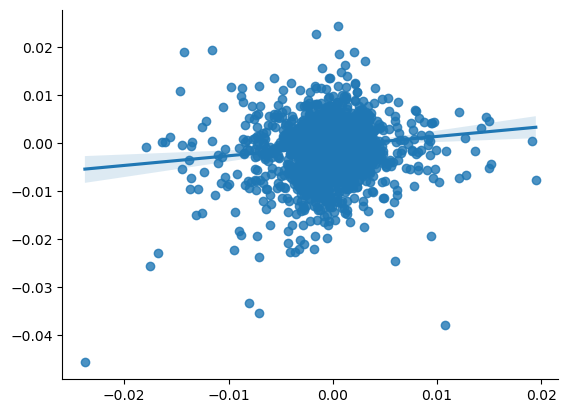

In [82]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,74], y=all_sess_betas[:].mean(0)[:,102])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,74], all_sess_betas[:].mean(0)[:,102])

SignificanceResult(statistic=-0.0323732074121875, pvalue=0.012057089330669596)

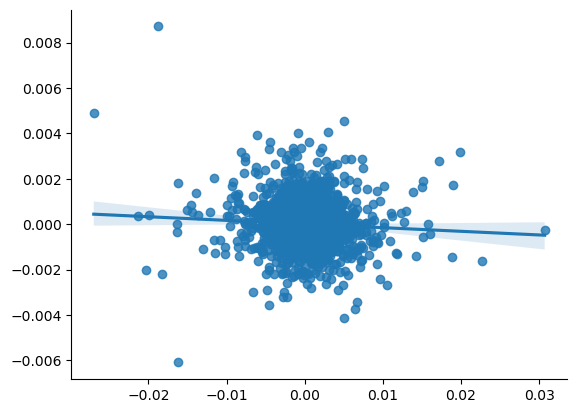

In [85]:
sns.regplot(x=all_sess_betas[:].mean(0)[:,100], y=all_sess_betas[:].mean(0)[:,156])
sns.despine()
spearmanr(all_sess_betas[:].mean(0)[:,100], all_sess_betas[:].mean(0)[:,156])